DASH 
Kibum Nam, Alexander Jesacher
Inst. of Biomed. Physics, Innsbruck University, Austria

This script demonstrates the DASH/c-DASH algorithms for aberration correction in 2-photon fluorescence microscopy.


In [7]:
#%% loading packages & defining functions

import numpy as np
from numpy import pi
from matplotlib.pyplot import * 
from numpy.fft import fftshift, ifftshift, fft2, ifft2, fftfreq
#from mkl_fft import fft2, ifft2 #faster if you have an Intel CPU
from scipy.ndimage import gaussian_filter


def normalize(C):
    """normalizing complex array C"""
    if C.ndim == 2:
        C = C[None, :, :]
    
    N = np.sum(np.abs(C)**2, axis=(1,2))
    C_norm = C/np.sqrt(N[:, None, None])*np.sqrt(N_modes)  
    return C_norm, N 

def make_sample(type):
    """creating a fluorescence sample"""
    if type == "bead":
        sample = np.ones((N, N))*1e-6 
        sample[0,0] = 1 
    elif type == "plane":
        sample = np.ones((N,N))
    return sample

def measure(scat, sample, E, padding = True, NL=2):
    """testing the correctin pattern C, i.e. measuring the 2-photon signal when it is applied to the SLM"""
       
    if E.ndim == 2:
        E = E[None, :, :]
    
    #optional padding to increase the spatial resolution in the focal plane
    if padding:
        tmp = fftshift(np.pad(ifftshift(scat*E, axes = (1,2)), [[0,0],[N,N],[N,N]]), axes = (1,2))
        sample = fftshift(np.pad(ifftshift(sample), N))
    else:    
        tmp = scat * E
    
    PSF = np.abs((fft2((tmp))) / N / N)**2  #intensity PSF in the focal plane
    signal = eta * np.sum(sample * PSF**NL, axis = (1,2)) ##2-photon signal
    
    return signal, PSF

def create_scat(N, P2V, sigma) :
    """creating a random phase scatterer, defined by peak-to-valley P2V and sigma"""
    scat = np.random.random((N,N))
    scat = gaussian_filter(scat, sigma)
    scat -= np.min(scat)
    scat /= np.max(scat)
    
    scat = ifftshift(np.exp(1j* P2V * scat))
    
    
    figure()
    imshow(ifftshift(np.angle(scat)), cmap = "hsv"); 
    colorbar(); 
    title("Scatterer phase")
    show()

    return scat

def create_modes(N):
    """creating the plane wave testmodes M"""
    # Create a grid of indices
    row, col = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    
    # Create the delta function matrix
    delta = np.zeros((N, N, N, N), dtype=complex)
    delta[row, col, row, col] = 1.0
    
    # Compute the FFT of the delta function matrix
    M = fftshift(fft2(ifftshift(delta, axes=(2, 3)), axes=(2, 3)), axes=(2, 3))
    
    # Compute the frequency
    freq = np.sqrt((row - N // 2) ** 2 + (col - N // 2) ** 2).flatten()
    
    # Sort the modes by frequency
    idx = np.argsort(freq)
    M = M.reshape(N * N, N, N)[idx]
    
    return M

    


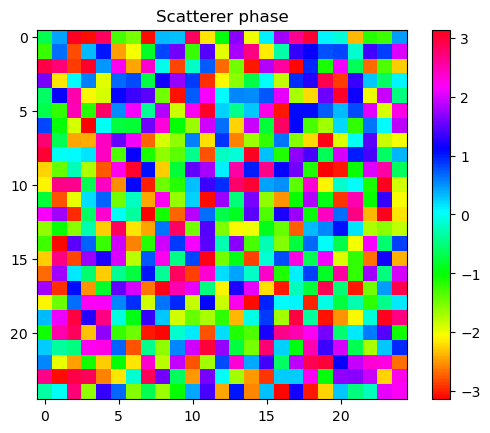

In [8]:
#%% create scatterer and modes

N = 25 # SLM & scattering media side length in pixels
N_modes = N**2  #no. of plane wave modes 
padding = True  #padding in Fourier plane to increase resolution in target plane

P2V = 2*pi  #peak to valley phase of scatterer
sigma_scat = .1    #gaussian blur kernel sigma of scatterer
scat = create_scat(N, P2V, sigma_scat) #calculate scatterer
M = create_modes(N) #calculating stack of plane-wave modes


In [9]:
#%% DASH user parameters

sample_type = "plane" # "bead" or "plane
method = "DASH" # "DASH" or "c-DASH"

N_i = 3  #number of iterations
N_p = 3 # number of phase steps

NL = 2 # non-linearity order (2 for two-photon fluorescence, 3 for three-photon fluorescence)
eta = 1e3 #signal generation efficieny
f = 0.2 #energy fraction of the testmodes
r0 = 1 #initial weight of the first mode


In [5]:
#----- DASH loop-------------

sample = make_sample(sample_type) #define fluorescent sample: 2D plane or "bead"
w = np.zeros((N_i, N_modes), dtype=complex) #init. mode weights
theta = np.arange(N_p) * 2 * pi / N_p #define phase-stepping angles

m0 = 1 #start with measuring the second mode in the first DASH iteration (the weight of the first mode is directly calculated from an initial measurement)

if padding:
    N_pad = 3*N
else: 
    N_pad = N

w0 = r0*(measure(scat, sample, np.ones((N,N)), padding, NL)[0]).item()**(1/(2*NL)) #initial weight for 1st mode
w[0,0] = w0

C_i = np.zeros((N_i, N, N), dtype=complex) #init. stack containing the correction patterns after each iteration
Imph_stack = np.zeros(N_i * (N**2) - m0) #init. stack of all TPEF signals
PSF_stack = np.zeros((N_i * (N**2) - m0, 1*N_pad, 1*N_pad)) #init. stack of all internsity PSFs
C = w0 * np.ones((N, N), dtype=complex)   #choice of initial correction pattern


mm = 0 #init. count index

for i in range(N_i):
    print("iteration = ", i)
      
    for m in range(m0,N_modes):
        
        m0 = 0 #from the 2nd iteration on, include a0 in the testing
            
        #A) phase stepping and measuring the signal
        if method == "DASH":
            E_SLM = np.exp(1j * np.angle(np.sqrt(f) * M[m][None, :,:] * np.exp(1j * theta[:,None, None]) + np.sqrt(1 - f) * normalize(C)[0]))
        elif method == "c-DASH":
            E_SLM = np.sqrt(f) * M[m][None, :, :] * np.exp(1j * theta[:, None, None]) + np.sqrt(1 - f) * normalize(C)[0] 
        
        Imph = measure(scat, sample, E_SLM, padding, NL)[0] #measuring TPEF signal for all phase steps -> vector I2ph
        S_avg = np.mean(Imph**(1/NL)) #average signal^(1/NL) over all phase steps
        a  = np.sum(Imph**(1/NL) * np.exp(1j * theta)) / len(theta)   
          
        #B) calculating the mode weight
        w_m = np.sqrt(1/2/f * (S_avg - np.sqrt(S_avg**2 - 4*np.abs(a)**2))).item() #calculating optimal amplitude of mode
        w[i,m] = w_m * np.exp(1j*np.angle(a))

        #C) updating correction pattern
        if i > 0 and method == "c-DASH":
            C += (w[i, m] - w[i-1,m]) * M[m] #for c-DASH subtracting old mode gives better results
        else:
            C += w[i, m] * M[m]
        
        #D) testing the correction pattern 
        if method == "DASH":
            Imph, PSF = measure(scat, sample, np.exp(1j*np.angle(C)), padding, NL) #testing the correction pattern C
            
        elif method == "c-DASH":
            Imph, PSF = measure(scat, sample, normalize(C)[0], padding, NL) #testing the correction pattern C
        
        Imph_stack[mm] = Imph[0]
        PSF_stack[mm, :, :] = fftshift(PSF)
        mm += 1

    C_i[i] = C


iteration =  0
iteration =  1
iteration =  2


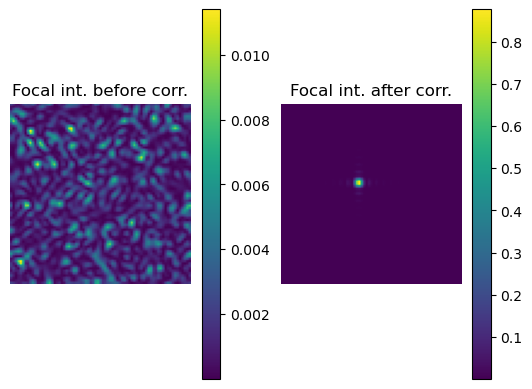

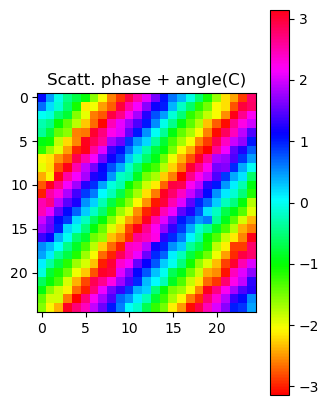

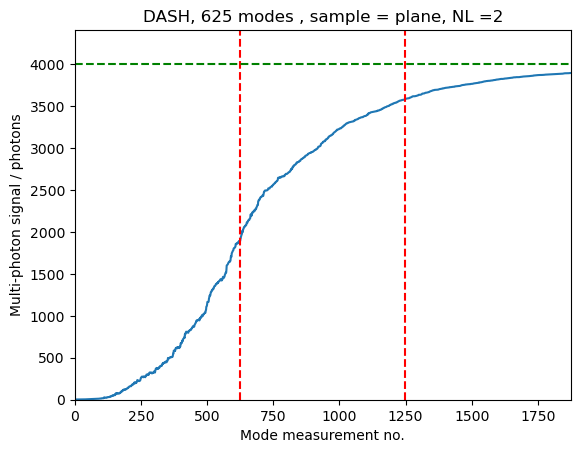

In [6]:
#showing results

figure()
subplot(121)
title("Focal int. before corr.")
imshow(PSF_stack[0])
axis("off")
colorbar()
subplot(122)
imshow(PSF_stack[-1])
colorbar()
axis("off")
title("Focal int. after corr.")
show()

figure(figsize=(12, 5))
subplot(131)
imshow(ifftshift(np.angle(scat * C)), cmap='hsv', vmin = -pi, vmax = pi)
colorbar()
title('Scatt. phase + angle(C)')
axis('image')

if method == "c-DASH":
    subplot(132)
    imshow(ifftshift(np.abs(C)), cmap='gray', vmin = 0)
    colorbar()
    title('abs(C)')
    axis('image')

Imph_max = measure(1, sample, np.ones((N,N)), padding, NL)[0].item()  #eval. max. signal for the aberration-free case

figure()
plot(Imph_stack)
ylim(0, Imph_max*1.1)
xlim(0, N_i * (N**2) - 1)
xlabel('Mode measurement no.')
ylabel('Multi-photon signal / photons')
axvline(x=N_modes-1, color='r', linestyle='--')
axvline(x=2*N_modes-1, color='r', linestyle='--')
axhline(y = Imph_max, color='g', linestyle='--')
title(method + ", " + str(N_modes) + " modes , sample = " + sample_type + ", NL =" + str(NL))
show()


# %%
